In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pickle as pkl
from descartes import PolygonPatch

from geopy.geocoders import Nominatim

import requests
import pandas as pd
import feedparser
from bs4 import BeautifulSoup
import urllib.request
import urllib3
import json
from pandas.io.json import json_normalize
import numpy as np

In [3]:
url = 'https://cagisonline.hamilton-co.org/arcgis/rest/services/COUNTYWIDE/CensusBoundaries/MapServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json'

cinci_census = gpd.read_file(url)
cinci_census.head()

,OBJECTID,TRACTCE10,geometry
0,1,005200,"POLYGON ((-84.43168 39.15720, -84.43177 39.156..."
1,2,005301,"POLYGON ((-84.42516 39.15576, -84.42513 39.155..."
2,3,005302,"POLYGON ((-84.40766 39.15576, -84.40748 39.155..."
3,4,005400,"POLYGON ((-84.42096 39.16456, -84.41972 39.163..."
4,5,005500,"POLYGON ((-84.39799 39.17441, -84.39800 39.174..."


In [4]:
url = 'https://cagisonline.hamilton-co.org/arcgis/rest/services/CINC_PLANNING/Cincinnati_Boundaries/MapServer/1/query?where=1%3D1&outFields=*&outSR=4326&f=json'

cinbdry = gpd.read_file(url)
cinbdry.head()

,OBJECTID,CAGIS.Cinc_City_Boundary.AREA,PERIMETER,BND_NAME,SQMI,GLOBALID,SHAPE.AREA,SHAPE.LEN,CREATED_USER,CREATED_DATE,LAST_EDITED_USER,LAST_EDITED_DATE,geometry
0,962,None,671358.22726,CINCINNATI,79.716,{3028B9D5-0B01-4F04-B4F9-22DBEA1F3C0C},0.0,0.0,cagis,1424811134000,cagis,1424811134000,"POLYGON ((-84.48208 39.21934, -84.48204 39.219..."


In [5]:
res_intersection = gpd.overlay(cinci_census, cinbdry, how='intersection')
res_cent = gpd.overlay(cinci_census, cinbdry, how='intersection')

In [6]:
tracts = []
for x in res_intersection['TRACTCE10']:
    #x = x[0:]
    n = x[:2]
    #print(x)
    if n == '00':
        x = x[2:]
        x = x[:2] + '.' + x[2:4]
    else:
        n = x[:1]
        x = x[1:]
        x = x[:3] + '.' + x[3:5]
    tracts.append(x)

res_intersection['TRACTCE10'] = tracts
res_cent['TRACTCE10'] = tracts

In [57]:
print(tracts)

None


In [7]:
indexs_drop = []
tracts_drop = [204.01,204.04,208.02,209.01,209.02,212.02,213.02,213.04,214.01,214.21,214.22,
               218.01,218.02,219.00,221.02,222.00,226.01,226.02,232.01,233.00,234.00,238.00,242.00,
               244.00,247.00,248.00,249.01,250.01,250.02,251.04,252.00,253.00,254.01,254.02,255.00,
               256.00,257.00,258.00,271.00,274.00]

tracts_drop = [str(i) for i in tracts_drop]

for i in range(len(res_intersection)):
    tract = res_intersection.loc[i,'TRACTCE10']
    if tract in tracts_drop:
        indexs_drop.append(i)

In [8]:
res_intersection = res_intersection[res_intersection['TRACTCE10'] != '208.11']
res_cent = res_cent[res_cent['TRACTCE10'] != '208.11']

res_intersection.reset_index(inplace=True)
res_intersection.drop(['index'], axis=1, inplace=True)
res_intersection.drop(indexs_drop, axis=0, inplace=True)
res_intersection.reset_index(inplace=True)
res_intersection.drop(['index'], axis=1, inplace=True)

res_cent.reset_index(inplace=True)
res_cent.drop(['index'], axis=1, inplace=True)
res_cent.drop(indexs_drop, axis=0, inplace=True)
res_cent.reset_index(inplace=True)
res_cent.drop(['index'], axis=1, inplace=True)


In [9]:
desired_columns = ['TRACTCE10', 'geometry']
res_intersection = res_intersection[desired_columns]
res_cent = res_cent[desired_columns]

In [10]:
res_cent['geometry'] = res_cent.centroid

In [11]:
def buffer_mi(df, miles):
    """takes geopandas dataframe and returns a buffer of miles from that point/polygon
    Args:
        df (geopandas dataframe) - geopandas dataframe to convert
        mile - number of miles that buffer is from points in geometry  
    Returns:
        convertedDF - new geopandas dataframe that has a polygon that is m miles buffer from original geometry
    """
    #Getting mile buffer for the outside of Tempe
    convertedDF = df.to_crs({'init': 'epsg:3174'})
    
    #converting from miles to meters
    buffer_length_in_meters = (miles * 1000) * 1.60934
    convertedDF['geometry'] = convertedDF.geometry.buffer(buffer_length_in_meters)

    convertedDF = convertedDF.to_crs({'init': 'epsg:4326'})
    
    convertedDF.reset_index(inplace=True)
    convertedDF.drop(['index'], axis=1, inplace=True)
    return(convertedDF)


def facility_within_cinbuffer(geo_df, cinbuffer):
    """takes geopandas dataframe and returns the points that are within the Tempe buffer
    Args:
        geo_df (geopandas dataframe) - geopandas dataframe to pull points from
        tempebuffer - geopandas dataframe made of the Cincinnati city mile buffer
    Returns:
        df_mi - new geopandas dataframe that the points within the Cincinnati buffer
    """
    df_mi = pd.DataFrame()
    for i in range(len(cinbuffer)):
        df = geo_df[geo_df.within(cinbuffer.loc[i,'geometry'])]
        df_mi = df_mi.append(df)
    df_mi.reset_index(inplace=True)
    df_mi.drop(['index'], axis=1, inplace=True)
    return(df_mi)

In [12]:
cinbdry_2mi = buffer_mi(cinbdry, 2)

In [13]:
cinCentroidConvertedB = buffer_mi(res_cent, 2)
cinCentroidConvertedB.head()

,TRACTCE10,geometry
0,52.00,"POLYGON ((-84.40009 39.15091, -84.40027 39.148..."
1,53.01,"POLYGON ((-84.39038 39.14994, -84.39056 39.147..."
2,53.02,"POLYGON ((-84.37619 39.14888, -84.37637 39.146..."
3,54.00,"POLYGON ((-84.38878 39.16124, -84.38896 39.158..."
4,55.00,"POLYGON ((-84.36472 39.16066, -84.36490 39.157..."


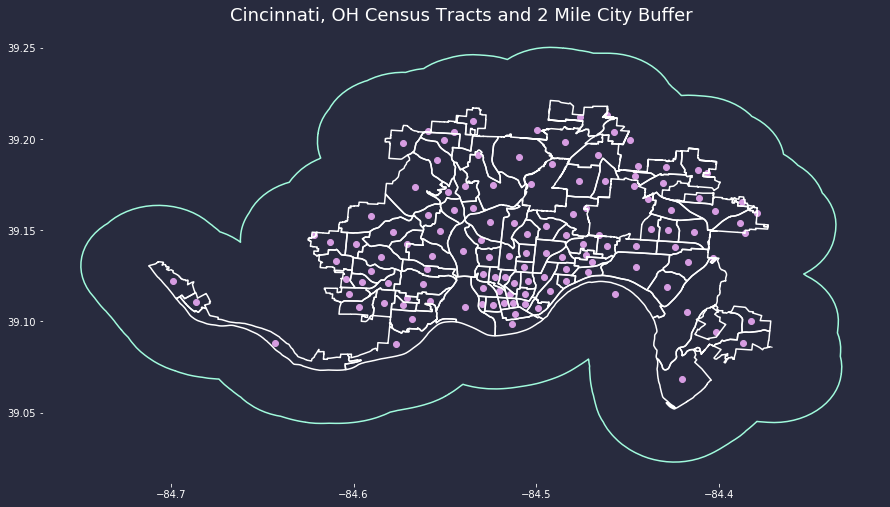

In [17]:
fig, ax = plt.subplots(figsize=(15,15))
fig.patch.set_facecolor('#282b3e')
ax.set_facecolor('#282b3e')
ax.spines['bottom'].set_color('#282b3e')
ax.spines['left'].set_color('#282b3e')
ax.spines['right'].set_color('#282b3e')
ax.spines['top'].set_color('#282b3e')
ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')


cinbdry_2mi.boundary.plot(ax=ax, color= '#a1fbdd')
res_intersection.boundary.plot(ax=ax,color='white')
res_cent.plot(ax=ax,color='#d69ce1')

plt.title("Cincinnati, OH Census Tracts and 2 Mile City Buffer", color = 'white', fontsize=18)
plt.savefig('CincinnatiCensus2MileWithoutCensusBuffers.png', facecolor="#282b3e", edgecolor='none')



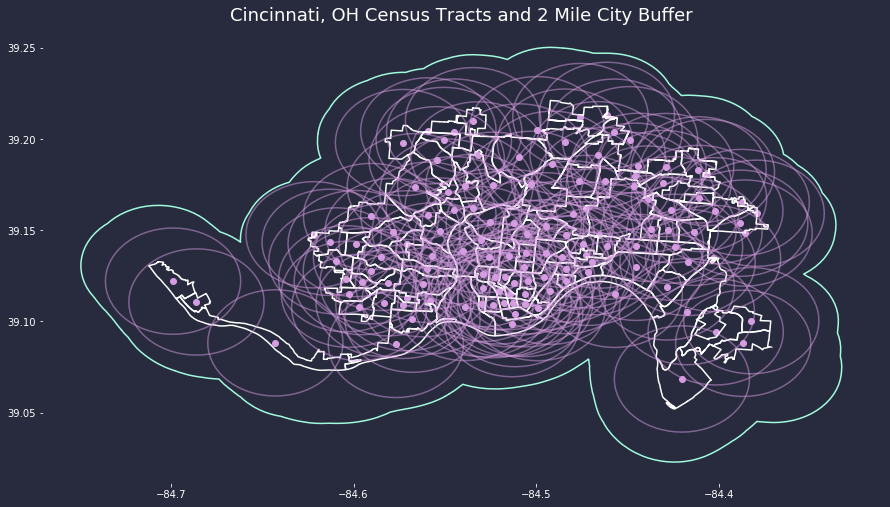

In [20]:
fig, ax = plt.subplots(figsize=(15,15))
fig.patch.set_facecolor('#282b3e')
ax.set_facecolor('#282b3e')
ax.spines['bottom'].set_color('#282b3e')
ax.spines['left'].set_color('#282b3e')
ax.spines['right'].set_color('#282b3e')
ax.spines['top'].set_color('#282b3e')
ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

cinbdry_2mi.boundary.plot(ax=ax, color= '#a1fbdd')
res_intersection.boundary.plot(ax=ax,color='white')
res_cent.plot(ax=ax,color='#d69ce1')

cinCentroidConvertedB.boundary.plot(ax=ax, color='#d69ce1',alpha='0.5')

plt.title("Cincinnati, OH Census Tracts and 2 Mile City Buffer", color = 'white', fontsize=18)
plt.savefig('CinNeigh2Mile.png')

In [41]:
for i in range(len(res_cent)):
    print(res_cent.loc[i])

TRACTCE10                                           52.00
geometry     POINT (-84.43717451303709 39.15092613930175)
Name: 0, dtype: object
TRACTCE10                                           53.01
geometry     POINT (-84.42746643703299 39.14995854039083)
Name: 1, dtype: object
TRACTCE10                                           53.02
geometry     POINT (-84.41327494034977 39.14890537255343)
Name: 2, dtype: object
TRACTCE10                                           54.00
geometry     POINT (-84.42587134842957 39.16126148854225)
Name: 3, dtype: object
TRACTCE10                                         55.00
geometry     POINT (-84.401813647384 39.16069096490372)
Name: 4, dtype: object
TRACTCE10                                           56.00
geometry     POINT (-84.38819186324139 39.15382653159347)
Name: 5, dtype: object
TRACTCE10                                           57.01
geometry     POINT (-84.42876957198564 39.18491310746934)
Name: 6, dtype: object
TRACTCE10                      

In [96]:
facilities =  pd.read_csv('DataFiles/FacilityData/MedicalFacilitiesWithin2milesCinFULL.csv')

In [87]:
def create_geo_df_mf_ct(df):
    """takes url and returns geopandas dataframe used for the Medical facilities.
    Args:
        url - queried from ArcGIS
        layer - name of the feature layer data was pulled from
    Returns:
        geo_df - new geopandas dataframe from that url
    """
    crs = {'init': 'epsg:4326'}
    
    ct_med = pd.DataFrame(df)
    ct_med.drop(['Unnamed: 0'], axis=1, inplace=True)
    
    geometry = [Point(xy) for xy in zip(ct_med['Long'],ct_med['Lat'])]

    geo_df = gpd.GeoDataFrame(ct_med, crs = crs, geometry = geometry)
    
    return(geo_df)

In [97]:
facilities = create_geo_df_mf_ct(facilities)
facilities

,ADDRESS,CITY,COUNTY,Lat,Layer,Long,NAME,TYPE,ZIP,geometry
0,85 North Grand Avenue,Ft. Thomas,Campbell,39.078705,Hospital,-84.466896,St. Elizabeth Ft. Thomas,HospitalsGeneral,41075,POINT (-84.46690 39.07870)
1,151 W Galbraith Rd,Cincinnati,Hamilton,39.213279,NaN,-84.478683,DANIEL DRAKE CENTER FOR POST-ACUTE CARE,HospitalsGeneral,45216,POINT (-84.47868 39.21328)
2,151 W Galbraith Rd,Cincinnati,Hamilton,39.213279,NaN,-84.478683,Encompass Health Rehabilitation Hospital of Ci...,HospitalsGeneral,45216,POINT (-84.47868 39.21328)
3,2139 Auburn Ave,Cincinnati,Hamilton,39.121175,NaN,-84.508677,CHRIST HOSPITAL,HospitalsGeneral,45219,POINT (-84.50868 39.12118)
4,2139 Auburn Ave Unit 3,Cincinnati,Hamilton,39.121175,NaN,-84.508677,DANIEL DRAKE CENTER FOR POST-ACUTE CARE,HospitalsGeneral,45219,POINT (-84.50868 39.12118)
5,2155 DANA AVENUE,CINCINNATI,HAMILTON,39.145225,NaN,-84.458690,TRIHEALTH REHABILITATION HOSPITAL LLC,HospitalsGeneral,45207,POINT (-84.45869 39.14523)
6,234 GOODMAN STREET,CINCINNATI,HAMILTON,39.136863,NaN,-84.502510,"UNIVERSITY OF CINCINNATI MEDICAL CENTER, LLC",HospitalsGeneral,45219,POINT (-84.50251 39.13686)
7,3200 Burnet Ave,Cincinnati,Hamilton,39.136742,NaN,-84.500679,UC - MEDICAL CENTER - RIDGEWAY,HospitalsGeneral,45229,POINT (-84.50068 39.13674)
8,3200 VINE ST,CINCINNATI,HAMILTON,39.137929,NaN,-84.509344,DEPARTMENT OF VETERANS AFFAIRS,HospitalsGeneral,45220,POINT (-84.50934 39.13793)
9,3300 MERCY HEALTH BLVD,CINCINNATI,HAMILTON,39.153800,NaN,-84.600900,MERCY HOSPITAL WEST,HospitalsGeneral,45211,POINT (-84.60090 39.15380)


In [98]:
hospitals_gen = facilities[facilities['TYPE'] == 'HospitalsGeneral']

hospitals_ment = facilities[facilities['TYPE'] == 'HospitalsPsych']

surgical_centers = facilities[facilities['TYPE'] == 'Surgery']

urgent_care = facilities[facilities['TYPE'] == 'UrgentCare']

womens_clinics = facilities[facilities['TYPE'] == 'WomensClinic']

pain_management = facilities[facilities['TYPE'] == 'PainManagement']

physical_therapy = facilities[facilities['TYPE'] == 'PhysicalTherapy']

mental_facilities = facilities[facilities['TYPE'] == 'Mental']

substance_help = facilities[facilities['TYPE'] == 'SubstanceHelp']

med_2mi = facilities[facilities['TYPE'] == 'MedicalFacility']

nursing_assisted = facilities[facilities['TYPE'] == 'NursingAssisted']

hospice_centers = facilities[facilities['TYPE'] == 'Hospice']

child_hospitals = facilities[facilities['TYPE'] == 'HospitalsChild']

child_facilities = facilities[facilities['TYPE'] == 'ChildFacility']


In [90]:
def counting_facilities_cn(df_2mi):
    """takes geopandas dataframe and returns the points that are within the Cincinnati buffer
    Args:
        convertedDF (geopandas dataframe) - mile buffer geopandas dataframe to count facilities from
    Returns:
        medfCounts (lst) - list of the number of facility buffer polygons 
                            (an m mile ring from the facility location) that 
                            contain the centroid of the neighborhood
    """
    df_2mi.reset_index(inplace=True)
    df_2mi.drop(['index'], axis=1, inplace=True)
    counts = {}
    medCounts = []
    n = len(df_2mi)-1
    for i in range(len(cinCentroidConvertedB)):
        loc1 = cinCentroidConvertedB.loc[i,'geometry']
        name = res_intersection.loc[i, 'TRACTCE10']
        fCount = 0
        for j in range(len(df_2mi)):
            loc2 = df_2mi.loc[j,'geometry']
            intersection = loc1.contains(loc2)
            if intersection == True:
                fCount += 1
            if j == n:
                counts[name] = fCount
                medCounts.append(fCount)
    print(counts)
    return(medCounts)

In [118]:
medFacCindf = pd.DataFrame()

medFacCindf['CensusTract'] = res_intersection['TRACTCE10']
medFacCindf['HospitalsGeneralCount2mi'] = counting_facilities_cn(hospitals_gen)
medFacCindf['HospitalsPsychCount2mi'] = counting_facilities_cn(hospitals_ment)
medFacCindf['SurgicalCentersCount2mi'] = counting_facilities_cn(surgical_centers)
medFacCindf['UrgentCareCount2mi'] = counting_facilities_cn(urgent_care)
medFacCindf['WomensClinicsCount2mi'] = counting_facilities_cn(womens_clinics)
medFacCindf['PainManagementCount2mi'] = counting_facilities_cn(pain_management)
medFacCindf['PhysicalTherapyCount2mi'] = counting_facilities_cn(physical_therapy)
medFacCindf['MentalFacilitiesCount2mi'] = counting_facilities_cn(mental_facilities)
medFacCindf['SubstanceAbuseCount2mi'] = counting_facilities_cn(substance_help)
medFacCindf['OtherMedicalFacilitesCount2mi'] = counting_facilities_cn(med_2mi)
medFacCindf['NursingAssistedLiveCount2mi'] = counting_facilities_cn(nursing_assisted)
medFacCindf['HospiceCount2mi'] = counting_facilities_cn(hospice_centers)
medFacCindf['HospitalsChildCount2mi'] = counting_facilities_cn(child_hospitals)
medFacCindf['ChildFacilitiesCount2mi'] = counting_facilities_cn(child_facilities)
medFacCindf.head()

{'52.00': 3, '53.01': 2, '53.02': 1, '54.00': 2, '55.00': 1, '56.00': 0, '57.01': 1, '57.02': 2, '58.00': 1, '59.00': 2, '60.00': 2, '61.00': 2, '63.00': 2, '64.00': 1, '65.00': 4, '219.00': 0, '222.00': 2, '233.00': 2, '234.00': 2, '238.00': 1, '242.00': 0, '244.00': 0, '247.00': 0, '248.00': 0, '252.00': 2, '253.00': 3, '255.00': 2, '256.00': 2, '257.00': 2, '258.00': 0, '263.00': 2, '264.00': 2, '265.00': 2, '266.00': 0, '267.00': 6, '268.00': 2, '269.00': 6, '270.00': 6, '271.00': 3, '272.00': 0, '274.00': 2, '02.00': 2, '07.00': 2, '09.00': 3, '10.00': 5, '11.00': 5, '66.00': 5, '68.00': 4, '69.00': 6, '70.00': 4, '71.00': 4, '72.00': 6, '73.00': 0, '74.00': 1, '75.00': 0, '77.00': 1, '78.00': 1, '79.00': 0, '80.00': 0, '81.00': 0, '82.01': 0, '82.02': 0, '83.00': 0, '84.00': 0, '85.01': 0, '85.02': 0, '86.01': 1, '16.00': 6, '17.00': 6, '18.00': 6, '19.00': 5, '20.00': 5, '88.00': 1, '92.00': 0, '93.00': 0, '94.00': 0, '95.00': 0, '96.00': 0, '97.00': 0, '98.00': 0, '99.01': 0, '

{'52.00': 2, '53.01': 2, '53.02': 3, '54.00': 2, '55.00': 3, '56.00': 2, '57.01': 1, '57.02': 1, '58.00': 2, '59.00': 1, '60.00': 0, '61.00': 0, '63.00': 0, '64.00': 0, '65.00': 0, '219.00': 0, '222.00': 0, '233.00': 0, '234.00': 0, '238.00': 3, '242.00': 2, '244.00': 2, '247.00': 1, '248.00': 2, '252.00': 1, '253.00': 1, '255.00': 0, '256.00': 1, '257.00': 0, '258.00': 0, '263.00': 0, '264.00': 0, '265.00': 0, '266.00': 0, '267.00': 2, '268.00': 2, '269.00': 2, '270.00': 2, '271.00': 0, '272.00': 0, '274.00': 0, '02.00': 0, '07.00': 0, '09.00': 2, '10.00': 2, '11.00': 2, '66.00': 2, '68.00': 2, '69.00': 2, '70.00': 2, '71.00': 1, '72.00': 1, '73.00': 0, '74.00': 0, '75.00': 0, '77.00': 0, '78.00': 0, '79.00': 0, '80.00': 0, '81.00': 0, '82.01': 0, '82.02': 0, '83.00': 1, '84.00': 0, '85.01': 0, '85.02': 0, '86.01': 0, '16.00': 2, '17.00': 2, '18.00': 2, '19.00': 2, '20.00': 2, '88.00': 0, '92.00': 0, '93.00': 0, '94.00': 0, '95.00': 0, '96.00': 0, '97.00': 0, '98.00': 0, '99.01': 0, '

{'52.00': 0, '53.01': 0, '53.02': 0, '54.00': 0, '55.00': 0, '56.00': 0, '57.01': 0, '57.02': 0, '58.00': 0, '59.00': 0, '60.00': 0, '61.00': 0, '63.00': 0, '64.00': 0, '65.00': 4, '219.00': 0, '222.00': 0, '233.00': 0, '234.00': 0, '238.00': 0, '242.00': 0, '244.00': 0, '247.00': 0, '248.00': 0, '252.00': 0, '253.00': 0, '255.00': 0, '256.00': 2, '257.00': 0, '258.00': 0, '263.00': 0, '264.00': 0, '265.00': 0, '266.00': 0, '267.00': 4, '268.00': 1, '269.00': 0, '270.00': 4, '271.00': 0, '272.00': 0, '274.00': 0, '02.00': 0, '07.00': 0, '09.00': 0, '10.00': 2, '11.00': 3, '66.00': 4, '68.00': 4, '69.00': 4, '70.00': 4, '71.00': 3, '72.00': 3, '73.00': 0, '74.00': 0, '75.00': 0, '77.00': 0, '78.00': 0, '79.00': 0, '80.00': 0, '81.00': 0, '82.01': 0, '82.02': 0, '83.00': 0, '84.00': 0, '85.01': 0, '85.02': 0, '86.01': 0, '16.00': 4, '17.00': 4, '18.00': 4, '19.00': 4, '20.00': 4, '88.00': 0, '92.00': 0, '93.00': 0, '94.00': 0, '95.00': 0, '96.00': 0, '97.00': 0, '98.00': 0, '99.01': 0, '

,CensusTract,HospitalsGeneralCount2mi,HospitalsPsychCount2mi,SurgicalCentersCount2mi,UrgentCareCount2mi,WomensClinicsCount2mi,PainManagementCount2mi,PhysicalTherapyCount2mi,MentalFacilitiesCount2mi,SubstanceAbuseCount2mi,OtherMedicalFacilitesCount2mi,NursingAssistedLiveCount2mi,HospiceCount2mi,HospitalsChildCount2mi,ChildFacilitiesCount2mi
0,52.00,3,1,7,6,0,1,2,1,1,9,9,2,0,0
1,53.01,2,1,7,6,0,1,2,1,1,9,7,2,0,0
2,53.02,1,1,4,5,0,1,3,1,1,7,8,1,0,0
3,54.00,2,1,7,6,0,1,2,1,1,9,6,2,0,0
4,55.00,1,1,2,4,0,1,3,0,1,6,10,1,0,0


In [100]:
oh_ph = pd.read_csv('cincinnati/OhioOneSource_Export_Pharm.csv')
oh_ph.head()

,Business Type,Business Name,Location Address Line 1,Location Address Line 2,Location City,Location State,Location Zip,Location County,VoicePhone,EmailAddress,...,LHDDistrict,ContractingWith,Website,BusinessTypeCategoryDesc,HospitalTypeDesc,NATCEPTypeDesc,Data Source,CombinedWith,LHDIdOld,Active Facility
0,II - Independent Community Pharmacy - 1 Outlet,ADRIEN PHARMACY,7023 MIAMI AVENUE,NaN,CINCINNATI,OH,45243,Hamilton,5135617700,B.MORRIS@FUSE.NET,...,NaN,NaN,NaN,Pharmacy Services,NaN,NaN,PharmacyBoard,NaN,NaN,True
1,II - Independent Community Pharmacy - 1 Outlet,BERNENS CONVALESCENT PHARMACY,5053 GLENWAY AVE.,NaN,CINCINNATI,OH,45238,Hamilton,5134717575,HENGELHARDT@BERNENS.COM,...,NaN,NaN,NaN,Pharmacy Services,NaN,NaN,PharmacyBoard,NaN,NaN,True
2,II - Independent Community Pharmacy - 1 Outlet,BROSSART PHARMACY,45 S. MIAMI AVENUE,NaN,CLEVES,OH,45002,Hamilton,5139410428,brossartpharmacy@gmail.com,...,NaN,NaN,NaN,Pharmacy Services,NaN,NaN,PharmacyBoard,NaN,NaN,True
3,CP - Clinic Pharmacy,CANN MEDICAL CENTER,5818 MADISON ROAD,CINCINNATI HEALTH DEPT.,CINCINNATI,OH,452271708,Hamilton,5132638760,PAUL.ABELN@CINCINNATI-OH.GOV,...,NaN,NaN,NaN,Pharmacy Services,NaN,NaN,PharmacyBoard,NaN,NaN,True
4,CP - Clinic Pharmacy,CCHMC INVESTIGATIONAL PHARMACY,619 OAK STREET - 2ND FLOOR,NaN,CINCINNATI,OH,45219,Hamilton,5136366278,DENISE.LAGORY@CCHMC.ORG,...,NaN,NaN,NaN,Pharmacy Services,NaN,NaN,PharmacyBoard,NaN,NaN,True


In [101]:
def create_geo_df_mf(df):
    """takes url and returns geopandas dataframe used for the Medical facilities.
    Args:
        url - queried from ArcGIS
        layer - name of the feature layer data was pulled from
    Returns:
        geo_df - new geopandas dataframe from that url
    """
    desired_cols = ['Business Type','Business Name', 'Location Address Line 1', 
                    'Location City', 'Location Zip', 
                    'Location County','LocationLat', 'LocationLong']

    medF_df = df[desired_cols]

    medF_df.columns =['TYPE', 'NAME', 'ADDRESS', 
                      'CITY', 'ZIP', 
                      'COUNTY','Lat', 'Long']

    crs = {'init': 'epsg:4326'}
    cin_med = pd.DataFrame(medF_df)

    geometry = [Point(xy) for xy in zip(cin_med['Long'],cin_med['Lat'])]

    geo_df = gpd.GeoDataFrame(cin_med, crs = crs, geometry = geometry)
    
    return(geo_df)

STILL MISSING MAJORITY KY DATA. THE WALGREENS POINT IS NOT INCLUDED IN THE 2 MILE RADIUS

In [119]:
ky_df = pd.read_csv('DataFiles/FacilityData/KYNaloxoneLocations.csv')

In [121]:
geometry = [Point(xy) for xy in zip(ky_df['Long'],ky_df['Lat'])]

geoky_ph_df = gpd.GeoDataFrame(ky_df, crs = crs, geometry = geometry)

In [122]:
geoph_df = create_geo_df_mf(oh_ph)
geoph_df

,TYPE,NAME,ADDRESS,CITY,ZIP,COUNTY,Lat,Long,geometry
0,II - Independent Community Pharmacy - 1 Outlet,ADRIEN PHARMACY,7023 MIAMI AVENUE,CINCINNATI,45243,Hamilton,39.188344,-84.363286,POINT (-84.36329 39.18834)
1,II - Independent Community Pharmacy - 1 Outlet,BERNENS CONVALESCENT PHARMACY,5053 GLENWAY AVE.,CINCINNATI,45238,Hamilton,39.121768,-84.601482,POINT (-84.60148 39.12177)
2,II - Independent Community Pharmacy - 1 Outlet,BROSSART PHARMACY,45 S. MIAMI AVENUE,CLEVES,45002,Hamilton,39.162278,-84.749199,POINT (-84.74920 39.16228)
3,CP - Clinic Pharmacy,CANN MEDICAL CENTER,5818 MADISON ROAD,CINCINNATI,452271708,Hamilton,39.160700,-84.396300,POINT (-84.39630 39.16070)
4,CP - Clinic Pharmacy,CCHMC INVESTIGATIONAL PHARMACY,619 OAK STREET - 2ND FLOOR,CINCINNATI,45219,Hamilton,39.127200,-84.513700,POINT (-84.51370 39.12720)
5,CP - Clinic Pharmacy,CINCINNATI HEALTH DEPARTMENT,1525 ELM STREET,CINCINNATI,45202,Hamilton,39.109500,-84.489000,POINT (-84.48900 39.10950)
6,IL - Large Chain Pharmacy - 12 or More Outlets,"COMMUNITY, A WALGREENS PHARMACY #16524","260 STETSON ST., STE F",CINCINNATI,45219,Hamilton,39.127200,-84.513700,POINT (-84.51370 39.12720)
7,IS - Small Chain Pharmacy - 2-11 Outlets,COSTCO PHARMACY #379,1100 EAST KEMPER ROAD,SPRINGDALE,45246,Hamilton,39.286548,-84.453374,POINT (-84.45337 39.28655)
8,IL - Large Chain Pharmacy - 12 or More Outlets,COSTCO PHARMACY #384,9691 WATERSTONE BLVD,CINCINNATI,45249,Hamilton,39.293677,-84.303775,POINT (-84.30378 39.29368)
9,IL - Large Chain Pharmacy - 12 or More Outlets,CVS PHARMACY #16422,900 E KEMPER RD,SPRINGDALE,45246,Hamilton,39.286904,-84.456834,POINT (-84.45683 39.28690)


In [123]:
geoPH_df = pd.concat([geoph_df, geoky_ph_df],axis=0,
                       ignore_index=True,sort=False)

In [124]:
geoPH_df = geoPH_df[geoPH_df['Lat']!=0]
print(len(geoPH_df))

166


In [126]:
geoPH_df = facility_within_cinbuffer(geoPH_df, cinbdry_2mi)
len(geoPH_df)

118

In [151]:
geoPH_df.to_csv(r'DataFiles/FilesCounts/CincinnatiPharmacyFinal.csv')

In [128]:
medFacCindf['PharmCount2mi'] = counting_facilities_cn(geoPH_df)

medFacCindf.head()

{'52.00': 13, '53.01': 15, '53.02': 12, '54.00': 15, '55.00': 11, '56.00': 6, '57.01': 7, '57.02': 10, '58.00': 8, '59.00': 9, '60.00': 5, '61.00': 6, '63.00': 6, '64.00': 8, '65.00': 8, '219.00': 6, '222.00': 6, '233.00': 7, '234.00': 8, '238.00': 8, '242.00': 3, '244.00': 5, '247.00': 11, '248.00': 6, '252.00': 12, '253.00': 12, '255.00': 4, '256.00': 9, '257.00': 6, '258.00': 3, '263.00': 12, '264.00': 15, '265.00': 16, '266.00': 7, '267.00': 25, '268.00': 23, '269.00': 21, '270.00': 22, '271.00': 6, '272.00': 4, '274.00': 8, '02.00': 13, '07.00': 18, '09.00': 20, '10.00': 21, '11.00': 21, '66.00': 16, '68.00': 14, '69.00': 20, '70.00': 19, '71.00': 17, '72.00': 20, '73.00': 5, '74.00': 8, '75.00': 4, '77.00': 6, '78.00': 7, '79.00': 2, '80.00': 3, '81.00': 2, '82.01': 6, '82.02': 4, '83.00': 10, '84.00': 3, '85.01': 4, '85.02': 4, '86.01': 4, '16.00': 25, '17.00': 23, '18.00': 24, '19.00': 21, '20.00': 19, '88.00': 6, '92.00': 6, '93.00': 5, '94.00': 11, '95.00': 9, '96.00': 5, '97

,CensusTract,HospitalsGeneralCount2mi,HospitalsPsychCount2mi,SurgicalCentersCount2mi,UrgentCareCount2mi,WomensClinicsCount2mi,PainManagementCount2mi,PhysicalTherapyCount2mi,MentalFacilitiesCount2mi,SubstanceAbuseCount2mi,OtherMedicalFacilitesCount2mi,NursingAssistedLiveCount2mi,HospiceCount2mi,HospitalsChildCount2mi,ChildFacilitiesCount2mi,PharmCount2mi
0,52.00,3,1,7,6,0,1,2,1,1,9,9,2,0,0,13
1,53.01,2,1,7,6,0,1,2,1,1,9,7,2,0,0,15
2,53.02,1,1,4,5,0,1,3,1,1,7,8,1,0,0,12
3,54.00,2,1,7,6,0,1,2,1,1,9,6,2,0,0,15
4,55.00,1,1,2,4,0,1,3,0,1,6,10,1,0,0,11


In [129]:
url = 'https://services3.arcgis.com/1pxU2hJU9ZszJDcX/ArcGIS/rest/services/PrescriptionDrugLocations/FeatureServer/1/query?where=%28name%3D%27Dayton+Police+Department%27%29+OR+%28name%3D%27Bellevue+Police+Department%27%29+OR+%28name%3D%27Newport+Police+Department%27%29+OR+%28name%3D%27Ft.+Thomas+Police+Department%27%29+OR+%28name%3D%27Park+Hills+Pollice+Department%27%29+OR+%28name%3D%27Southgate+Police+Department%27%29+OR+%28name%3D%27Villa+Hills+Police+Department%27%29+OR+%28name%3D%27Covington+Police+Department%27%29+OR+%28name%3D%27Ft.+Wright+Police+Department%27%29+OR+%28name%3D%27Wilder+Police+Department%27%29+OR+%28municipality%3D%27CINCINNATI%27%29+OR+%28municipality%3D%27NORWOOD%27%29&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&returnGeodetic=false&outFields=*&returnGeometry=true&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pjson&token='

resp = requests.get(url)
print(resp)

data_raw = resp.json()

CNdd_data = pd.io.json.json_normalize(data_raw['features'])

desired_cols = ['attributes.name','attributes.fulladdr','attributes.municipality']

CNdd_df = CNdd_data[desired_cols]

CNdd_df.columns =['Name','FullAddr','City']

CNdd_df = CNdd_df[:-3]

<Response [200]>


In [130]:
url = 'https://services5.arcgis.com/cd1xypoX1AbRtEm7/arcgis/rest/services/KioskDisposal_Final/FeatureServer/0/query?where=%28CITY+%3D+%27CINCINNATI%27%29+OR+%28CITY+%3D+%27FLORENCE%27%29&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&returnGeodetic=false&outFields=*&returnGeometry=true&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pjson&token='
resp = requests.get(url)
print(resp)

data_raw = resp.json()

CNddWAL_data = pd.io.json.json_normalize(data_raw['features'])

CNddWAL_data.columns

desired_cols = ['attributes.STORE_NBR','attributes.ADDRESS_LINE_1','attributes.CITY','attributes.STATE_ABBV']

CNddWAL_df = CNddWAL_data[desired_cols]

CNddWAL_df.columns =['StoreNbr','FullAddr','City','State']

CNddWAL_df['Name'] = 'Walgreens'



<Response [200]>


/Users/maddiewarndorf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [131]:
CNddWAL_df1 = CNddWAL_df[CNddWAL_df['State'] == 'OH']
CNddWAL_df2 = CNddWAL_df[CNddWAL_df['State'] == 'KY']

CNddWAL_df = pd.concat([CNddWAL_df1, CNddWAL_df2],axis=0,
                       ignore_index=True,sort=False)

CNddWAL_df

,StoreNbr,FullAddr,City,State,Name
0,11630,6918 HAMILTON AVE,CINCINNATI,OH,Walgreens
1,12830,3 W CORRY ST,CINCINNATI,OH,Walgreens
2,4245,5403 N BEND RD,CINCINNATI,OH,Walgreens
3,4246,2320 BOUDINOT AVE,CINCINNATI,OH,Walgreens
4,4522,9775 COLERAIN AVE,CINCINNATI,OH,Walgreens
5,2694,385 NORTHLAND BLVD,CINCINNATI,OH,Walgreens
6,5763,8193 MALL RD,FLORENCE,KY,Walgreens


In [133]:
CNddWAL_df = CNddWAL_df[CNddWAL_df['FullAddr']!= '2320 BOUDINOT AVE']
CNddWAL_df = CNddWAL_df[CNddWAL_df['FullAddr']!= '9775 COLERAIN AVE']

CNdd_df = pd.concat([CNdd_df, CNddWAL_df],axis=0,
                       ignore_index=True,sort=False)

CNdd_df

,Name,FullAddr,City,StoreNbr,State
0,Covington Police Department,None,None,NaN,NaN
1,Dayton Police Department,None,None,NaN,NaN
2,Ft. Thomas Police Department,None,None,NaN,NaN
3,Ft. Wright Police Department,None,None,NaN,NaN
4,Newport Police Department,None,None,NaN,NaN
5,Park Hills Pollice Department,None,None,NaN,NaN
6,Southgate Police Department,None,None,NaN,NaN
7,Villa Hills Police Department,None,None,NaN,NaN
8,Wilder Police Department,None,None,NaN,NaN
9,Bellevue Police Department,None,None,NaN,NaN


In [134]:
crs = {'init': 'epsg:4326'}
def drugdrop_address_cn(df):
    """takes dataframe and returns the latitude and longitude and makes geopandas dataframe 
    Args:
        df (dataframe) - dataframe to get addresses from
    Returns:
        geo_df - new geopandas dataframe that has the latitude and longitude of the points
    """
    new_df = pd.DataFrame()
    addresses = []
    lats = []
    longs = []
    c_df = df
    c_df.reset_index(inplace=True)
    c_df.drop(['index'], axis=1, inplace=True)

    geolocator = Nominatim(user_agent="my_app", format_string='%s, OH')
    for i in range(len(c_df)):
        #print(c_df.loc[i,'City'])
        address = c_df.loc[i,'FullAddr']
        state = c_df.loc[i, 'State']
        #print(address)
        name = c_df.loc[i, 'Name']
        if state == 'KY':
            geolocator = Nominatim(user_agent="my_app", format_string='%s, KY')
        location = geolocator.geocode(address)
        #print(location)
        if name == 'Covington Police Department':
                address = '1 Police Memorial Dr'
                lat= float(39.067168)
                long = float(-84.506221)
        elif name == 'Dayton Police Department':
                address = '514 6th Ave'
                lat= float(39.112319)
                long = float(-84.473531)
        elif name == 'Bellevue Police Department':
                address = '616 Poplar St'
                lat= float(39.106398)
                long = float(-84.478687)
        elif name == 'Ft. Thomas Police Department':
                address = '130 N Ft Thomas Ave'
                lat = float(39.081129)
                long = float(-84.448954)
        elif name == 'Newport Police Department':
                address = '998 Monmouth St'
                lat= float(39.067168)
                long = float(-84.506221)
        elif name == 'Park Hills Pollice Department':
                address = '1106 Amsterdam Rd'
                lat= float(39.081099)
                long = float(-84.448953)
        elif name == 'Southgate Police Department':
                address = '301 W Walnut St'
                lat= float(39.066238)
                long = float(-84.480746)
        elif name == 'Villa Hills Police Department':
                address = '719 Rogers Rd'
                lat= float(39.052315)
                long = float(-84.597368)
        elif name == 'Ft. Wright Police Department':
                address = '409 Kyles Ln'
                lat= float(39.051953)
                long = float(-84.536246)
        elif name == 'Wilder Police Department':
                address = '520 Licking Pike'
                lat= float(39.054794)
                long = float(-84.488206)
        else:
            lat = location.latitude
            long = location.longitude
        addresses.append(address)
        lats.append(lat)
        longs.append(long)
    c_df['Lat'] = lats
    c_df['Long'] = longs
    new_df = c_df
    new_df['FullAddr'] = addresses
    geometry = [Point(xy) for xy in zip(new_df['Long'],new_df['Lat'])]
    geo_df = gpd.GeoDataFrame(new_df, crs = crs, geometry = geometry)
    return(geo_df)

In [114]:
geoCNdd_df = drugdrop_address_cn(CNdd_df)
geoCNdd_df

,Name,FullAddr,City,StoreNbr,State,Lat,Long,geometry
0,Covington Police Department,1 Police Memorial Dr,None,NaN,NaN,39.067168,-84.506221,POINT (-84.50622 39.06717)
1,Dayton Police Department,514 6th Ave,None,NaN,NaN,39.112319,-84.473531,POINT (-84.47353 39.11232)
2,Ft. Thomas Police Department,130 N Ft Thomas Ave,None,NaN,NaN,39.081129,-84.448954,POINT (-84.44895 39.08113)
3,Ft. Wright Police Department,409 Kyles Ln,None,NaN,NaN,39.051953,-84.536246,POINT (-84.53625 39.05195)
4,Newport Police Department,998 Monmouth St,None,NaN,NaN,39.067168,-84.506221,POINT (-84.50622 39.06717)
5,Park Hills Pollice Department,1106 Amsterdam Rd,None,NaN,NaN,39.081099,-84.448953,POINT (-84.44895 39.08110)
6,Southgate Police Department,301 W Walnut St,None,NaN,NaN,39.066238,-84.480746,POINT (-84.48075 39.06624)
7,Villa Hills Police Department,719 Rogers Rd,None,NaN,NaN,39.052315,-84.597368,POINT (-84.59737 39.05232)
8,Wilder Police Department,520 Licking Pike,None,NaN,NaN,39.054794,-84.488206,POINT (-84.48821 39.05479)
9,Bellevue Police Department,616 Poplar St,None,NaN,NaN,39.106398,-84.478687,POINT (-84.47869 39.10640)


In [148]:
geoCNdd_df = facility_within_cinbuffer(geoCNdd_df, cinbdry_2mi)
len(geoCNdd_df)

12

In [150]:
geoCNdd_df.to_csv(r'DataFiles/FilesCounts/CincinnatiDrugDropFinal.csv')

In [136]:
medFacCindf['DrugDropCount2mi'] = counting_facilities_cn(geoCNdd_df)

medFacCindf

{'52.00': 1, '53.01': 0, '53.02': 0, '54.00': 0, '55.00': 0, '56.00': 0, '57.01': 0, '57.02': 0, '58.00': 0, '59.00': 0, '60.00': 0, '61.00': 0, '63.00': 0, '64.00': 0, '65.00': 1, '219.00': 0, '222.00': 0, '233.00': 0, '234.00': 0, '238.00': 0, '242.00': 0, '244.00': 0, '247.00': 0, '248.00': 0, '252.00': 0, '253.00': 0, '255.00': 1, '256.00': 1, '257.00': 0, '258.00': 0, '263.00': 0, '264.00': 1, '265.00': 1, '266.00': 2, '267.00': 4, '268.00': 3, '269.00': 1, '270.00': 2, '271.00': 0, '272.00': 0, '274.00': 0, '02.00': 1, '07.00': 2, '09.00': 1, '10.00': 2, '11.00': 3, '66.00': 2, '68.00': 2, '69.00': 2, '70.00': 1, '71.00': 2, '72.00': 2, '73.00': 1, '74.00': 1, '75.00': 1, '77.00': 1, '78.00': 1, '79.00': 1, '80.00': 0, '81.00': 0, '82.01': 0, '82.02': 0, '83.00': 0, '84.00': 1, '85.01': 2, '85.02': 1, '86.01': 0, '16.00': 1, '17.00': 1, '18.00': 3, '19.00': 3, '20.00': 4, '88.00': 1, '92.00': 0, '93.00': 0, '94.00': 0, '95.00': 0, '96.00': 0, '97.00': 1, '98.00': 1, '99.01': 1, '

,CensusTract,HospitalsGeneralCount2mi,HospitalsPsychCount2mi,SurgicalCentersCount2mi,UrgentCareCount2mi,WomensClinicsCount2mi,PainManagementCount2mi,PhysicalTherapyCount2mi,MentalFacilitiesCount2mi,SubstanceAbuseCount2mi,OtherMedicalFacilitesCount2mi,NursingAssistedLiveCount2mi,HospiceCount2mi,HospitalsChildCount2mi,ChildFacilitiesCount2mi,PharmCount2mi,DrugDropCount2mi
0,52.00,3,1,7,6,0,1,2,1,1,9,9,2,0,0,13,1
1,53.01,2,1,7,6,0,1,2,1,1,9,7,2,0,0,15,0
2,53.02,1,1,4,5,0,1,3,1,1,7,8,1,0,0,12,0
3,54.00,2,1,7,6,0,1,2,1,1,9,6,2,0,0,15,0
4,55.00,1,1,2,4,0,1,3,0,1,6,10,1,0,0,11,0
5,56.00,0,0,2,3,0,1,2,0,1,3,9,1,0,0,6,0
6,57.01,1,1,1,3,0,0,1,1,0,3,2,0,0,0,7,0
7,57.02,2,1,7,5,0,1,1,0,0,6,3,1,0,0,10,0
8,58.00,1,1,2,4,0,1,2,0,0,5,9,0,0,0,8,0
9,59.00,2,2,5,4,0,0,1,1,0,8,6,1,0,0,9,0


In [137]:
cin_nal = pd.read_csv('DataFiles/FacilityData/CinNaloxoneLocations.csv')

In [138]:
cin_nal

,Unnamed: 0,LicenseNumber,Phone,BusinessName,LocationStreetAddress,LocationCity,LocationState,LocationZip,LocationCounty,FullAddr,Lat,Long,geometry
0,0,22463050,(513) 862-3550,BETHESDA NORTH APOTHECARY,10500 MONTGOMERY RD,CINCINNATI,OH,45242,Hamilton,"10500 MONTGOMERY RD, CINCINNATI, OH",39.143702,-84.470209,POINT (-84.47020910000001 39.1437024)
1,1,20253100,(513) 263-8760,CANN MEDICAL CENTER,5818 Madison Rd,Cincinnati,OH,45227-1708,Hamilton,"5818 Madison Rd, Cincinnati, OH",39.161121,-84.393476,POINT (-84.3934759 39.1611207)
2,2,20345000,5133523094,CINCINNATI HEALTH DEPARTMENT,1525 ELM STREET ELM STREET HEALTH CENTER,CINCINNATI,OH,45202,Hamilton,"1525 ELM STREET ELM STREET HEALTH CENTER, CINC...",39.112119,-84.519647,POINT (-84.5196466389599 39.112119)
3,3,22571200,(401) 765-1500,CVS PHARMACY #16779,4825A MARBURG AVE.,CINCINNATI,OH,45209,Hamilton,"4825A MARBURG AVE., CINCINNATI, OH",39.163264,-84.424729,POINT (-84.4247287449664 39.1632641073825)
4,4,22571300,(401) 765-1500,CVS PHARMACY #16873,9040 COLERAIN AVE.,CINCINNATI,OH,45251,Hamilton,"9040 COLERAIN AVE., CINCINNATI, OH",39.166881,-84.553554,POINT (-84.5535539 39.1668806)
5,5,22572450,(401) 765-1500,CVS PHARMACY #17534,6150 GLENWAY AVE.,CINCINNATI,OH,45211,Hamilton,"6150 GLENWAY AVE., CINCINNATI, OH",39.144228,-84.622311,POINT (-84.6223112000467 39.1442278631911)
6,6,22013700,(401) 765-1500,CVS/PHARMACY # 6087,7700 HAMILTON AVENUE,MOUNT HEALTHY,OH,45231,Hamilton,"7700 HAMILTON AVENUE, MOUNT HEALTHY, OH",39.233649,-84.547988,POINT (-84.547988 39.233649)
7,7,22013100,(401) 765-1500,CVS/PHARMACY # 6097,9525 KENWOOD ROAD SUITE 1,CINCINNATI,OH,45242,Hamilton,"9525 KENWOOD ROAD SUITE 1, CINCINNATI, OH",39.162074,-84.385604,POINT (-84.385604 39.162074)
8,8,22013150,(401) 765-1500,CVS/PHARMACY # 6100,5811 COLERAIN AVENUE,CINCINNATI,OH,45239,Hamilton,"5811 COLERAIN AVENUE, CINCINNATI, OH",39.166881,-84.553554,POINT (-84.5535539 39.1668806)
9,9,22013200,(401) 765-1500,CVS/PHARMACY # 6101,8560 WINTON ROAD,CINCINNATI,OH,45231,Hamilton,"8560 WINTON ROAD, CINCINNATI, OH",39.179607,-84.519747,POINT (-84.5197474 39.1796072)


In [139]:
geometry = [Point(xy) for xy in zip(cin_nal['Long'],cin_nal['Lat'])]

geocn_df = gpd.GeoDataFrame(cin_nal, crs = crs, geometry = geometry)

In [141]:
geocn_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [143]:
geoCinN_df = pd.concat([geocn_df, geoky_ph_df],axis=0,
                       ignore_index=True,sort=False)
geoCinN_df.head()


,LicenseNumber,Phone,BusinessName,LocationStreetAddress,LocationCity,LocationState,LocationZip,LocationCounty,FullAddr,Lat,Long,geometry,Unnamed: 0,Name,City
0,22463050.0,(513) 862-3550,BETHESDA NORTH APOTHECARY,10500 MONTGOMERY RD,CINCINNATI,OH,45242,Hamilton,"10500 MONTGOMERY RD, CINCINNATI, OH",39.143702,-84.470209,POINT (-84.47021 39.14370),NaN,NaN,NaN
1,20253100.0,(513) 263-8760,CANN MEDICAL CENTER,5818 Madison Rd,Cincinnati,OH,45227-1708,Hamilton,"5818 Madison Rd, Cincinnati, OH",39.161121,-84.393476,POINT (-84.39348 39.16112),NaN,NaN,NaN
2,20345000.0,5133523094,CINCINNATI HEALTH DEPARTMENT,1525 ELM STREET ELM STREET HEALTH CENTER,CINCINNATI,OH,45202,Hamilton,"1525 ELM STREET ELM STREET HEALTH CENTER, CINC...",39.112119,-84.519647,POINT (-84.51965 39.11212),NaN,NaN,NaN
3,22571200.0,(401) 765-1500,CVS PHARMACY #16779,4825A MARBURG AVE.,CINCINNATI,OH,45209,Hamilton,"4825A MARBURG AVE., CINCINNATI, OH",39.163264,-84.424729,POINT (-84.42473 39.16326),NaN,NaN,NaN
4,22571300.0,(401) 765-1500,CVS PHARMACY #16873,9040 COLERAIN AVE.,CINCINNATI,OH,45251,Hamilton,"9040 COLERAIN AVE., CINCINNATI, OH",39.166881,-84.553554,POINT (-84.55355 39.16688),NaN,NaN,NaN


In [149]:
geoCinN_df.to_csv(r'DataFiles/FilesCounts/CincinnatiNaloxoneFinal.csv')

In [144]:
medFacCindf['NaloxoneDistribCount2mi'] = counting_facilities_cn(geoCinN_df)

medFacCindf.head()

{'52.00': 16, '53.01': 13, '53.02': 12, '54.00': 12, '55.00': 11, '56.00': 5, '57.01': 9, '57.02': 8, '58.00': 8, '59.00': 10, '60.00': 7, '61.00': 6, '63.00': 6, '64.00': 5, '65.00': 11, '219.00': 3, '222.00': 4, '233.00': 7, '234.00': 10, '238.00': 8, '242.00': 3, '244.00': 4, '247.00': 10, '248.00': 5, '252.00': 10, '253.00': 10, '255.00': 9, '256.00': 11, '257.00': 8, '258.00': 5, '263.00': 11, '264.00': 11, '265.00': 9, '266.00': 3, '267.00': 19, '268.00': 13, '269.00': 16, '270.00': 15, '271.00': 8, '272.00': 6, '274.00': 7, '02.00': 13, '07.00': 12, '09.00': 12, '10.00': 12, '11.00': 12, '66.00': 13, '68.00': 14, '69.00': 16, '70.00': 17, '71.00': 25, '72.00': 23, '73.00': 16, '74.00': 19, '75.00': 16, '77.00': 16, '78.00': 19, '79.00': 15, '80.00': 5, '81.00': 10, '82.01': 3, '82.02': 3, '83.00': 4, '84.00': 17, '85.01': 12, '85.02': 14, '86.01': 6, '16.00': 18, '17.00': 15, '18.00': 14, '19.00': 13, '20.00': 13, '88.00': 15, '92.00': 7, '93.00': 7, '94.00': 7, '95.00': 5, '96.

,CensusTract,HospitalsGeneralCount2mi,HospitalsPsychCount2mi,SurgicalCentersCount2mi,UrgentCareCount2mi,WomensClinicsCount2mi,PainManagementCount2mi,PhysicalTherapyCount2mi,MentalFacilitiesCount2mi,SubstanceAbuseCount2mi,OtherMedicalFacilitesCount2mi,NursingAssistedLiveCount2mi,HospiceCount2mi,HospitalsChildCount2mi,ChildFacilitiesCount2mi,PharmCount2mi,DrugDropCount2mi,NaloxoneDistribCount2mi
0,52.00,3,1,7,6,0,1,2,1,1,9,9,2,0,0,13,1,16
1,53.01,2,1,7,6,0,1,2,1,1,9,7,2,0,0,15,0,13
2,53.02,1,1,4,5,0,1,3,1,1,7,8,1,0,0,12,0,12
3,54.00,2,1,7,6,0,1,2,1,1,9,6,2,0,0,15,0,12
4,55.00,1,1,2,4,0,1,3,0,1,6,10,1,0,0,11,0,11


In [145]:
medFacCindf['geometry'] = res_intersection['geometry']

medFacCindf.head()

,CensusTract,HospitalsGeneralCount2mi,HospitalsPsychCount2mi,SurgicalCentersCount2mi,UrgentCareCount2mi,WomensClinicsCount2mi,PainManagementCount2mi,PhysicalTherapyCount2mi,MentalFacilitiesCount2mi,SubstanceAbuseCount2mi,OtherMedicalFacilitesCount2mi,NursingAssistedLiveCount2mi,HospiceCount2mi,HospitalsChildCount2mi,ChildFacilitiesCount2mi,PharmCount2mi,DrugDropCount2mi,NaloxoneDistribCount2mi,geometry
0,52.00,3,1,7,6,0,1,2,1,1,9,9,2,0,0,13,1,16,"POLYGON ((-84.43168 39.15720, -84.43177 39.156..."
1,53.01,2,1,7,6,0,1,2,1,1,9,7,2,0,0,15,0,13,"POLYGON ((-84.42516 39.15576, -84.42513 39.155..."
2,53.02,1,1,4,5,0,1,3,1,1,7,8,1,0,0,12,0,12,"POLYGON ((-84.40766 39.15576, -84.40748 39.155..."
3,54.00,2,1,7,6,0,1,2,1,1,9,6,2,0,0,15,0,12,"POLYGON ((-84.42096 39.16456, -84.41972 39.163..."
4,55.00,1,1,2,4,0,1,3,0,1,6,10,1,0,0,11,0,11,"MULTIPOLYGON (((-84.39309 39.16722, -84.39303 ..."


In [147]:
with open('DataFiles/countMedicalFacilitiesWithin2milesCinbyTract.pkl', 'wb') as pkl_file:
    pkl.dump(medFacCindf, pkl_file)

with open('CINCINcountMedicalFacilitiesWithin2milesCinbyTract.pkl', 'wb') as pkl_file:
    pkl.dump(medFacCindf, pkl_file)